# Stabilizer Codes Based on Random Circuits

A brielf tutorial describing the use of the Julia library `QuantumClifford` for the simulation and evaluation of error correcting codes derived from the evolution of local Clifford circuits. Inspired by "Quantum coding with low-depth random circuits" by Michael J. Gullans, Stefan Krastanov, David A. Huse, Liang Jiang, Steven T. Flammia, [arXiv:2010.09775](https://arxiv.org/abs/2010.09775)

In [1]:
using QuantumClifford
using Plots # For plotting. It takes a while to precompile the first time

To install these libraries go to package mode (press `]`) and type
`add QuantumClifford Plots`

## Initial Example with a Small Number of Qubits

### Setting up the tableaux data structures

First we need to create a tableau that will track what our brickwork circuit is doing. We can do that with a Stabilizer string literal:

In [2]:
state = S"+XXX
          -ZZI
          +IZZ"

+ XXX
- ZZ_
+ _ZZ

But one can create specific tableaux programatically as well (useful for large tableaux). The julia function `one` is typically used to create identity elements of a given class.

In [3]:
N = 2^4 # Number of qubits for our examples
initial_state = one(Stabilizer, N) # Use `one` to create the "identity" object of given class and size

+ Z_______________
+ _Z______________
+ __Z_____________
+ ___Z____________
+ ____Z___________
+ _____Z__________
+ ______Z_________
+ _______Z________
+ ________Z_______
+ _________Z______
+ __________Z_____
+ ___________Z____
+ ____________Z___
+ _____________Z__
+ ______________Z_
+ _______________Z

It is easier to view large stabilizer states as matrix plots:

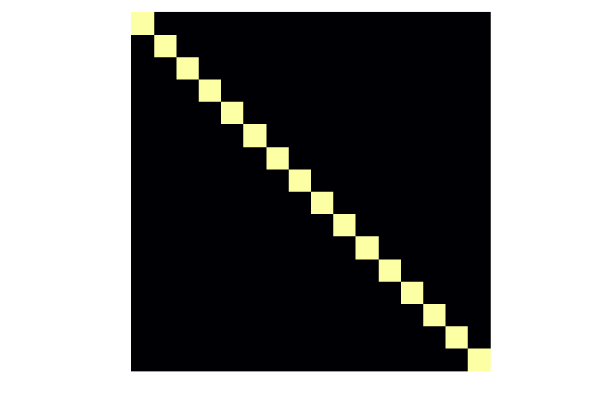

In [4]:
plot(initial_state, xzcomponents=:together)

### Clifford Operator data structures

This library provides not only tableaux but also varios operators that can act on the tableax, representing a quantum Clifford gate. They are implemented in multiple different data structures, depending on what operations are to be done most efficiently. The most common one is `CliffordOperator` that simply stores the transformation of the diagonal tableaux. It can be instantiated with a literal:

In [5]:
op = C"XZ
       ZX
       ZI
       IZ"

X_ ⟼ + XZ
_X ⟼ + ZX
Z_ ⟼ + Z_
_Z ⟼ + _Z


The `CPHASE`, `CNOT`, `Hadamard`, `Phase` gates are built in.

Tensor products between gates is implemented as well:

In [6]:
Phase ⊗ Hadamard # Use the slash+tab key combination to enter latex symbols

X_ ⟼ + Y_
_X ⟼ + _Z
Z_ ⟼ + Z_
_Z ⟼ + _X


### The brickwork layers of local Clifford Operators

To construct our brick layers, we can use `tensor_pow` to make the first layer for bricks, and `permute` to shift it by one and create the second layer of bricks.

In [7]:
brick_layer1 = tensor_pow(CNOT, N÷2); # Get the tensor product of N÷2 CNOT gates
# ÷ implies integer division (instead of float division with /)
brick_layer2 = permute(brick_layer1, [(2:N)...,1]);

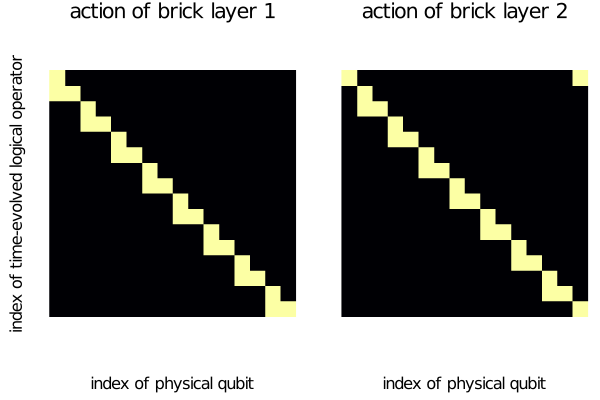

In [8]:
p1 = plot(brick_layer1*initial_state, xzcomponents=:together, title="action of brick layer 1", xlabel="index of physical qubit", ylabel="index of time-evolved logical operator")
p2 = plot(brick_layer2*initial_state, xzcomponents=:together, title="action of brick layer 2", xlabel="index of physical qubit")
plot(p1,p2)

In between these brick layers we will put layers of random single-qubit unitaries. They can be generated by the `random_singlequbitop` function. As a side note, the data structure used for them is `CliffordColumnForm` and not `CliffordOp`, which permits certain optimizations, but brings constraints as well (some operations are not implemented).

Finally, we can make a function that applies the layers (with a set of random single-qubit unitaries in between).

We use the `apply!(state, operator)` syntax instead of `operator*state`, as this performs the operation in-place, without copies and new memory allocations. We also turn off the calculation of relative phases. 

In [9]:
function apply_single_layer!(state)
    n = nqubits(state) # Find the size of the state
    apply!(state, random_singlequbitop(n), phases=false)
    apply!(state, brick_layer1, phases=false)
    apply!(state, random_singlequbitop(n), phases=false)
    apply!(state, brick_layer2, phases=false)
    return state
end

apply_single_layer! (generic function with 1 method)

**TODO** more sophisticated or optimized versions would use extra features like:

- This library will be better and faster if we have an in-place `apply_random_singlequbitop` instead of having to create a new random operator each time (saving on memory allocation).
- We need general random Clifford operators, not just `random_singlequbitop`. These more general functions would need their own allocation-free in-place `apply_random_*` versions.

We will visualize the results of repeated applications of these brick layers below. Notice we use the `copy` function if we want to save intermediary results.

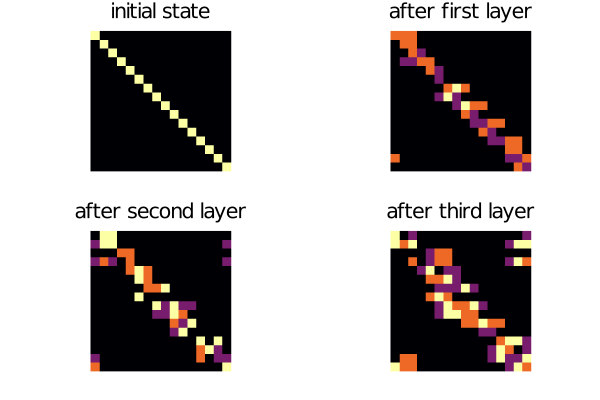

In [10]:
test_state = copy(initial_state)
apply_single_layer!(test_state)
first_application = copy(test_state)
apply_single_layer!(test_state)
second_application = copy(test_state)
apply_single_layer!(test_state)
third_application = copy(test_state)
plot(
  plot(initial_state, xzcomponents=:together, title="initial state"),
  plot(first_application, xzcomponents=:together, title="after first layer"),
  plot(second_application, xzcomponents=:together, title="after second layer"),
  plot(third_application, xzcomponents=:together, title="after third layer"),
)

### Extracting the stabilizer operators for the code

We just need each odd row from the tableau.

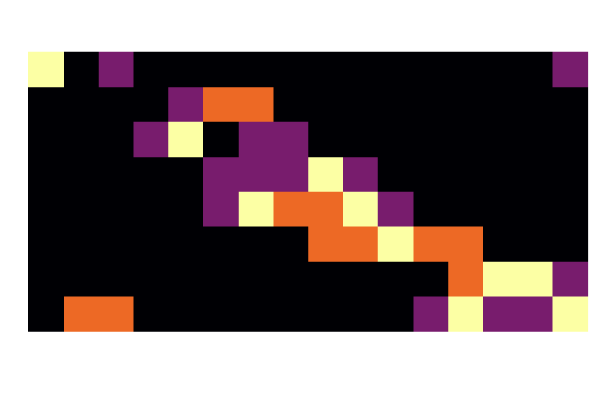

In [11]:
code = test_state[1:2:end]
plot(code,xzcomponents=:together)

### Extracting the generating set of syndromes

The matrix S is the matrix of commutators between code stabilizer operators and error operators. Its rank carries information about the error correction probability of a perfect syndrome decoder.

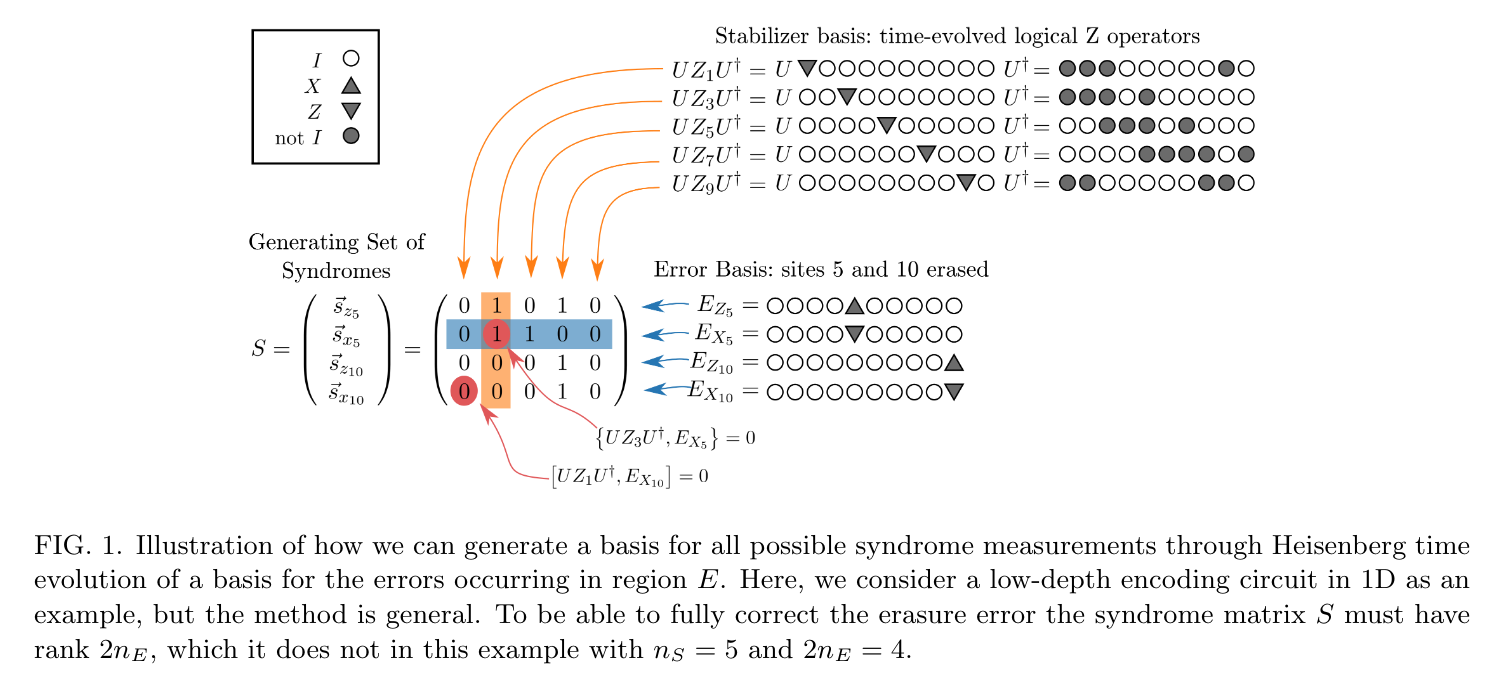

In [12]:
syndrome_mat = zeros(Bool, 2*N, N÷2) # 2N possible errors for rows vs N÷2 possible code stabilizers for columns
for i in 1:N
    for j in 1:N÷2
        syndrome_mat[i,j] = comm(code[j],single_z(N,i))
    end
end
for i in 1:N
    for j in 1:N÷2
        syndrome_mat[i+N,j] = comm(code[j],single_x(N,i))
    end
end

Consider an error rate of 0.25. We randomly select 1/4 of the qubits to be erased and extract the corresponding submatrix.

In [13]:
using Random # part of the standard library, it contains the `randperm` function
indices_of_erased_qubits = randperm(N)[1:N÷4]
S = syndrome_mat[[indices_of_erased_qubits...,indices_of_erased_qubits.+N...],:]

8×8 Array{Bool,2}:
 0  0  0  0  0  1  1  1
 0  0  0  0  1  0  0  0
 0  0  0  1  1  1  0  0
 0  1  0  0  1  0  0  0
 0  0  0  0  0  0  0  1
 0  0  1  1  0  0  0  0
 0  0  0  1  0  0  0  0
 0  0  1  1  1  0  0  0

The `AbstractAlgebra` package contains convenient functions for dealing with vector spaces over arbitrary fields. We will use that package to find the rank of the above binary matrix. We could have used `AbstractAlgebra` to do the entirety of this project given that the tableaux we work with are simply matrices over $\mathrm{GF}(2,2)$, but we would have sacrificed multiple low-level optimizations available in `QuantumClifford`.

In [14]:
using AbstractAlgebra

In [15]:
binary_field = GF(2)
Sbinary = matrix(binary_field, S) # TODO probably not the fastest way to convert the type of this matrix
r = rank(Sbinary)

7

In [16]:
recovery_probability = 2.0^(r-N÷2)

0.5

## Observing the threshold depth at which error correction becomes possible

We will perform the derivation described in the previous section for various depths and sampling over multiple different random circuits and multiple different random patterns.

In [17]:
Ns = [2^4, 2^5, 2^6, 2^7] # number of qubits for which we will perform the analysis
max_depth = 25 # depth to which we will test each circuit
nb_circuits = 100 # number of circuits we will average over
nb_error_samples = 10; # number of random error pattenrs over which we will average

In [18]:
using ProgressMeter # A library that provides the convenient @showprogress macro
using Base.Threads # A library that can turn ordinary loops into parallel multi-threaded "loops"

In [19]:
# Put all this in a function so julia can auto-compile it for faster execution
function get_all_samples(Ns,max_depth,nb_circuits,nb_error_samples)
    # an array that will contain the computed recovery probability for each circuit
    samples = zeros(length(Ns), max_depth, nb_circuits, nb_error_samples)

    for (index_N,N) in enumerate(Ns)
        println("Sampling from circuits of size $(N)")
        brick_layer1 = tensor_pow(CNOT, N÷2)
        brick_layer2 = permute(brick_layer1, [(2:N)...,1])
        @showprogress for index_circuit in 1:nb_circuits
            state = one(Stabilizer, N)
            for index_depth in 1:max_depth
                apply!(state, random_singlequbitop(N), phases=false)
                apply!(state, brick_layer1, phases=false)
                apply!(state, random_singlequbitop(N), phases=false)
                apply!(state, brick_layer2, phases=false)
                code = state[1:2:end]
                syndrome_mat = zeros(Bool, 2*N, N÷2)
                for i in 1:N
                    for j in 1:N÷2
                        syndrome_mat[i,j] = comm(code[j],single_z(N,i))
                    end
                end
                for i in 1:N
                    for j in 1:N÷2
                        syndrome_mat[i+N,j] = comm(code[j],single_x(N,i))
                    end
                end
                @threads for index_sample in 1:nb_error_samples
                    indices_of_erased_qubits = randperm(N)[1:N÷4] # error rate of 0.25
                    S = syndrome_mat[[indices_of_erased_qubits...,indices_of_erased_qubits.+N...],:]
                    Sbinary = matrix(binary_field, S)
                    r = rank(Sbinary)
                    recovery_probability = 2.0^(r-N÷2) # N_erased = N÷4
                    samples[index_N,index_depth,index_circuit,index_sample] = recovery_probability
                end
            end
        end
    end
    return samples
end

get_all_samples (generic function with 1 method)

In [20]:
samples = get_all_samples(Ns,max_depth,nb_circuits,nb_error_samples);

Sampling from circuits of size 16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Sampling from circuits of size 32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Sampling from circuits of size 64


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


Sampling from circuits of size 128


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


Based on these samples we can calculate means and standard errors.

In [21]:
using Statistics

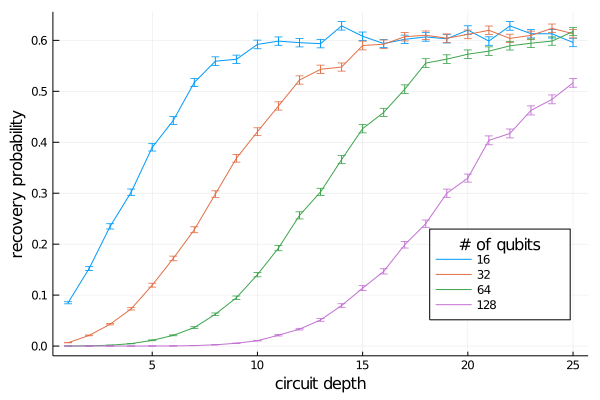

In [22]:
sample_means = mean(samples, dims=(3,4))
sample_errs = std(samples, dims=(3,4)) / sqrt(nb_circuits*nb_error_samples)
sample_means = dropdims(sample_means, dims=(3,4))
sample_errs = dropdims(sample_errs, dims=(3,4))
plot(1:max_depth,sample_means', yerror=sample_errs',
     label=["$(N)" for N in Ns'],legend=:bottomright,legendtitle="# of qubits",
     xlabel="circuit depth",ylabel="recovery probability")

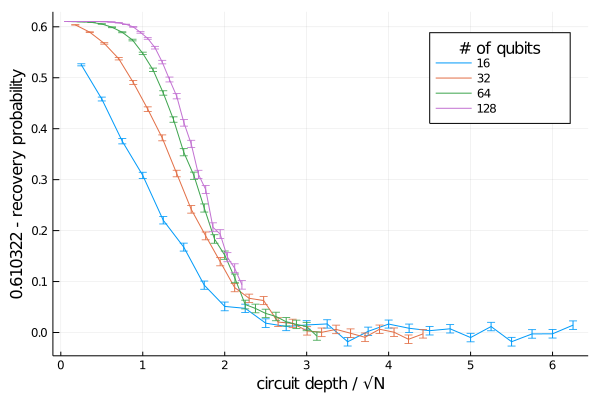

In [23]:
plot((1:max_depth) ./ sqrt.(Ns)', 0.610322 .- sample_means', yerror=sample_errs',
     label=["$(N)" for N in Ns'],legend=:topright,legendtitle="# of qubits",
     xlabel="circuit depth / √N",ylabel="0.610322 - recovery probability")

## Reproducibility information

In [24]:
versioninfo()

Julia Version 1.5.0
Commit 96786e22cc (2020-08-01 23:44 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


`QuantumClifford` commit `2f176f21d3ba39469c6ebc5669db5aa5266bf79b`